<a href="https://colab.research.google.com/github/Babitha23/Cyberbullying-detection/blob/main/data_preprocessing_and_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Required Libraries

In [ ]:
import torch
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [ ]:
#Importing all the libraries to be used
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics
!pip install wordcloud
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from google.colab import drive
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Data Extraction

In [ ]:
from google.colab import drive
import pickle

# Connect to google drive
drive.mount('/content/gdrive')

# Load data and set labels
data = pickle.load(open('gdrive/My Drive/Dissertation/formspring_data.pkl', 'rb'))
df = pd.DataFrame(data)

Mounted at /content/gdrive


In [ ]:
#check shape of the dataframes
print(df.shape)

(12773, 2)


In [ ]:
df.loc[0]['text']

'what is your favorite song ? d i like too many songs to have a favorite'

## Exploratory data analysis

In [ ]:
df.head()

,text,label
0,what is your favorite song ? d i like too many...,0
1,3 3 ? haha jk ! 33,0
2,hey angel you duh sexy really ? ! ? ! thanks ?...,0
3,,0
4,meowww rawr ?,0


Text(0, 0.5, 'Number of Data points')

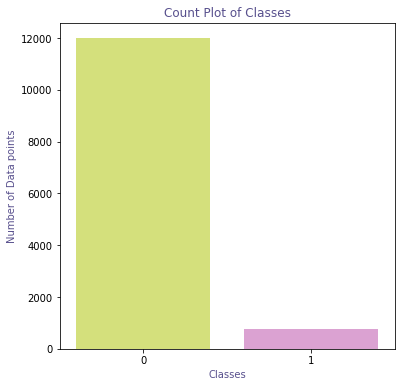

In [ ]:
#Palette
cols= ["#E1F16B", "#E598D8"] 
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(6,6))
fg = sns.countplot(x= df["label"], palette= cols)
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

In [ ]:
#Adding a column of numbers of charachters,words and sentences in each msg
df["No_of_Characters"] = df["text"].apply(len)
df["No_of_Words"]=df.apply(lambda row: nltk.word_tokenize(row["text"]), axis=1).apply(len)
df["No_of_sentence"]=df.apply(lambda row: nltk.sent_tokenize(row["text"]), axis=1).apply(len)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
label,12773.0,0.060753,0.238886,0.0,0.0,0.0,0.0,1.0
No_of_Characters,12773.0,117.250920,127.701501,0.0,52.0,86.0,146.0,5371.0
No_of_Words,12773.0,25.418931,26.966479,0.0,12.0,19.0,32.0,1102.0
No_of_sentence,12773.0,2.257105,1.638235,0.0,2.0,2.0,3.0,71.0


Comment: The huge difference between 75% quartile and max value shows the presence of outliers.

In [ ]:
df.head()

,text,label,No_of_Characters,No_of_Words,No_of_sentence
0,what is your favorite song ? d i like too many...,0,71,16,2
1,3 3 ? haha jk ! 33,0,18,7,3
2,hey angel you duh sexy really ? ! ? ! thanks ?...,0,53,14,4
3,,0,0,0,0
4,meowww rawr ?,0,13,3,1


Text(0.5, 1.0, 'The spread of characters')

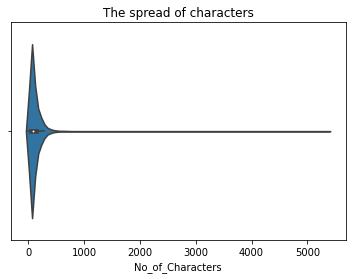

In [ ]:
sns.violinplot(x=df['No_of_Characters'])
plt.title("The spread of characters")

<Figure size 864x576 with 0 Axes>

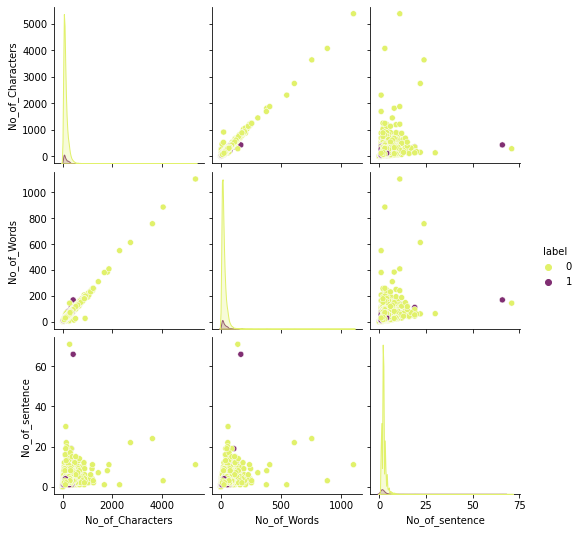

In [ ]:
#Palette
cols= ["#E1F16B", "#802E72"]
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df, hue="label",palette=cols)
plt.show(fg)

From the pair plot, we can see a few outliers all in both the classes. This is interesting as we could put a cap over one of these. As they essentially indicate the same thing ie the length of SMS.

Next, I shall be dropping the outliers

## Removing outliers

In [ ]:
Q1 = np.percentile(df['No_of_Characters'], [25, 50, 75])
Q1

array([ 52.,  86., 146.])

In [ ]:
Q1 = np.percentile(df['No_of_Characters'], 25)
Q3 = np.percentile(df['No_of_Characters'],75)
IQR = Q3 - Q1

In [ ]:
IQR

94.0

In [ ]:
data = df[(df['No_of_Characters'] > (Q1 - 1.5*IQR)) & (df['No_of_Characters'] < (Q1 + 1.5*IQR))]

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
label,10810.0,0.056522,0.230937,0.0,0.0,0.0,0.0,1.0
No_of_Characters,10810.0,82.433395,44.230528,0.0,47.0,74.0,112.0,192.0
No_of_Words,10810.0,18.180296,9.609200,0.0,11.0,16.0,24.0,69.0
No_of_sentence,10810.0,2.072063,1.153853,0.0,1.0,2.0,2.0,30.0


In [ ]:
data.tail(5)

,text,label,No_of_Characters,No_of_Words,No_of_sentence
12767,your thoughts on 2012 ? i think it will be an ...,0,110,25,2
12769,youu2019re awesome give yourself a compliment ...,0,91,18,3
12770,yu play with yurself ? all the time sometimes ...,0,66,14,2
12771,yukk beer is disgusting i can only drink it wh...,0,143,33,2
12772,if i told u den it would make it all the less ...,0,114,27,1


In [ ]:
data.isnull().sum()

text                0
label               0
No_of_Characters    0
No_of_Words         0
No_of_sentence      0
dtype: int64

Text(0, 0.5, 'Number of Data points')

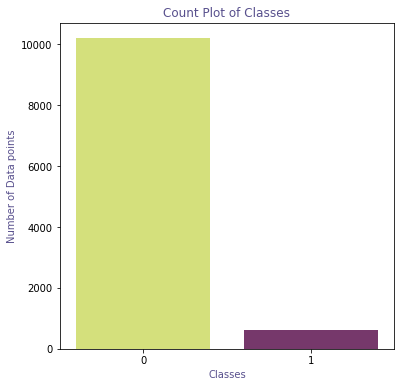

In [ ]:
plt.figure(figsize=(6,6))
fg = sns.countplot(x= data["label"], palette= cols)
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

In [ ]:
data.label.value_counts()

0    10199
1      611
Name: label, dtype: int64

<Figure size 864x576 with 0 Axes>

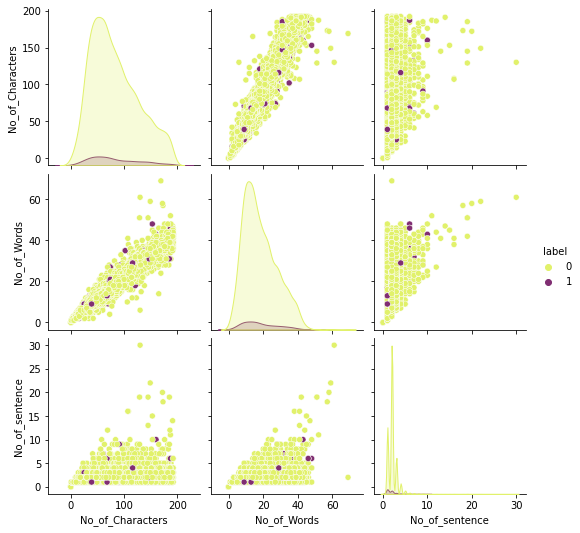

In [ ]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="label",palette=cols)
plt.show(fg)

Number of words and characters look much better now. But number of sentences still needs our attention.

In [ ]:
Q1 = np.percentile(df['No_of_sentence'], 25)
Q3 = np.percentile(df['No_of_sentence'],75)
IQR = Q3 - Q1
IQR

1.0

In [ ]:
data = data[(data['No_of_sentence'] > (Q1 - 1.5*IQR)) & (data['No_of_sentence'] < (Q1 + 1.5*IQR))]

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
label,10099.0,0.056441,0.230783,0.0,0.0,0.0,0.0,1.0
No_of_Characters,10099.0,80.309734,43.440157,1.0,46.0,71.0,109.0,192.0
No_of_Words,10099.0,17.540549,9.256807,1.0,10.0,16.0,23.0,69.0
No_of_sentence,10099.0,1.868799,0.632609,1.0,1.0,2.0,2.0,3.0


<Figure size 864x576 with 0 Axes>

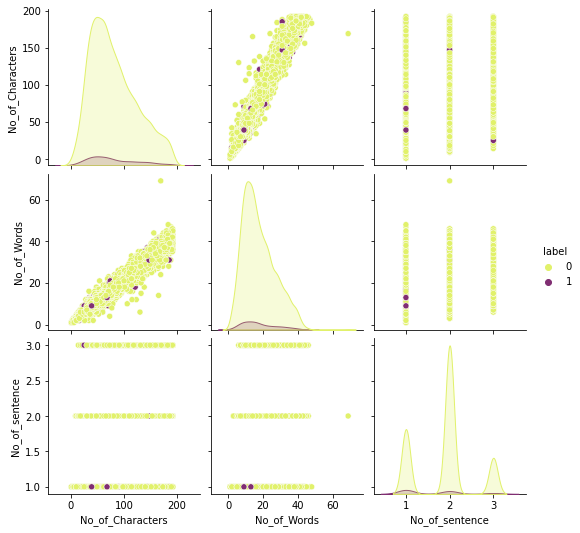

In [ ]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="label",palette=cols)
plt.show(fg)

Much better!!

#Data cleaning

In [ ]:
import string
def cleancomments(text):
  text = ''.join([i for i in text if not i.isdigit()]) #removing numbers
  text = ' '.join( [w for w in text.split() if len(w)>1]) #removing single characters
  return text
def removepunct(txt):
  remove = string.punctuation
  remove = remove.replace(".", "") # don't remove dot
  pattern = r"[{}]".format(remove) # create the pattern
  text = re.sub(pattern, "", txt)
  text = re.sub(' +', ' ', text) #remove additional whitespaces
  return text

In [ ]:
for i in range(len(data)):
  data['text'] = data['text'].apply(lambda x: cleancomments(x))
  data['text'] = data['text'].apply(lambda y: removepunct(y))

In [ ]:
data.sample()

,text,label,No_of_Characters,No_of_Words,No_of_sentence
7745,love you love you more,0,28,8,1


##Tokenization

In [ ]:
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["text"]), axis=1)
 
print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*data["Tokenize_Text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['what', 'is', 'your', 'favorite', 'song', 'like', 'too', 'many', 'songs', 'to', 'have', 'favorite']
['haha', 'jk']
['meowww', 'rawr']
['are', 'you', 'morning', 'or', 'night', 'person', 'night', 'shuree']
['are', 'you', 'trusting', 'person', 'alreadi', 'answrd']


##Stopword removal

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Removing the stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*data["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['favorite', 'song', 'like', 'many', 'songs', 'favorite']
['haha', 'jk']
['meowww', 'rawr']
['morning', 'night', 'person', 'night', 'shuree']
['trusting', 'person', 'alreadi', 'answrd']


###Lemmatization

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*data["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after lemitization:
['favorite', 'song', 'like', 'many', 'songs', 'favorite']
['haha', 'jk']
['meowww', 'rawr']
['morning', 'night', 'person', 'night', 'shuree']
['trust', 'person', 'alreadi', 'answrd']


###Vectorization

In [ ]:
#Creating a corpus of text feature to encode further into vectorized form
corpus= []
for i in data["Lemmatized_Text"]:
    txt = ' '.join([row for row in i])
    corpus.append(txt)
    
corpus[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

 The First 5 lines in corpus :
[ ' f a v o r i t e ' ,   ' s o n g ' ,   ' l i k e ' ,   ' m a n y ' ,   ' s o n g s ' ,   ' f a v o r i t e ' ]
[ ' h a h a ' ,   ' j k ' ]
[ ' m e o w w w ' ,   ' r a w r ' ]
[ ' m o r n i n g ' ,   ' n i g h t ' ,   ' p e r s o n ' ,   ' n i g h t ' ,   ' s h u r e e ' ]
[ ' t r u s t ' ,   ' p e r s o n ' ,   ' a l r e a d i ' ,   ' a n s w r d ' ]


In [ ]:
data.to_csv("gdrive/My Drive/Dissertation/processeddata.csv")

In [ ]:
data = pd.read_csv("gdrive/My Drive/Dissertation/processeddata.csv")

In [ ]:
data = data.dropna(axis=0)

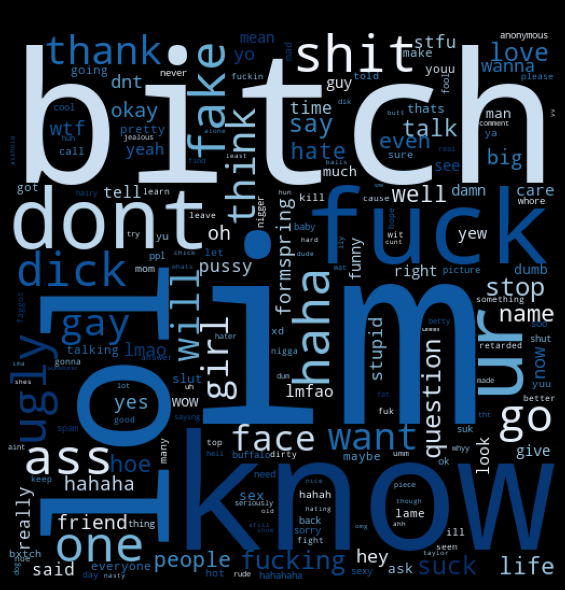

In [ ]:
def wc(label, title):
  terms = ' '.join(list(data[data['label'] == label]['text']))
  wcl = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(terms)
  plt.figure(figsize = (10, 8), facecolor = 'k')
  plt.imshow(wcl)
  plt.axis('off')
  plt.title(title, fontsize =25)
  plt.tight_layout(pad = 0)
  plt.show()

wc(1, 'Cyberbullying')

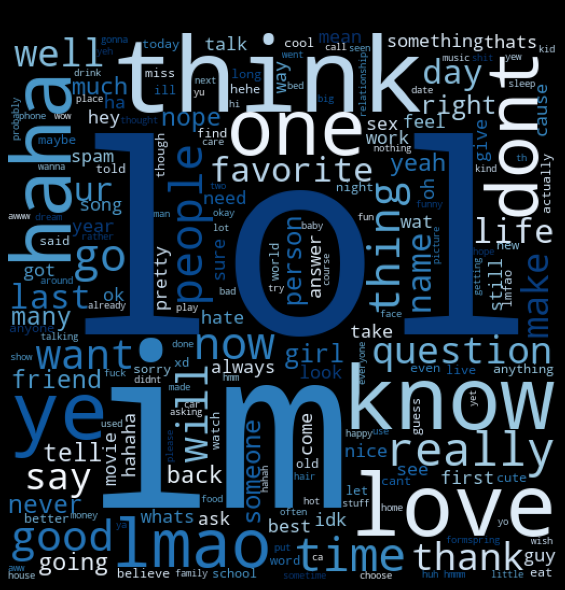

In [ ]:
wc(0, 'Non-bullying')